In [5]:
import numpy as np
import matplotlib.pyplot as plt
#import time
%matplotlib inline  

# Gaunersdorfer & Hommes 2007 model

Andrea Gaunersdorfer and Cars Hommes. A nonlinear structural model for volatility clustering. In A. Kirman and G. Teyssiere, editors, Micro Economic Models for Long Memory in Economics, pages 265–288. Springer-Verlag, 2007.

Andrea Gaunersdorfer, Cars H. Hommes, and Florian O. O. Wagener. Bifurcation routes to volatility clustering under evolutionary learning. Journal of Economic Behavior and Organization, 67:27–47, 2008.

http://people.brandeis.edu/~blebaron/classes/agentfin/GaunersdorferHommes.html

In [66]:
HISTORY = 4
NRUNS = 50

In [2]:
parameters = {
    'chaos': 0,
    'risk_x_average_variance': 1,
    'dividends': 1,
    'discount_rate': 0.001,
    'intensity_of_choice':2,
    'fundamentalist_adaptive_parameter':1,
    'chartist_adaptive_parameter':1.9,
    'bubble_sensitivity':1800,
    'fitness_memory_strenght':0.99,
    'risk_adjustment':0,
    'noise_std': 10,
    'init_price_dev_fundament': -400,
    'init_type2_agents': 0.5,
    'init_type2_holdings': 0.5
}

In [67]:
# initialise model
time = 10000 
chaos = 0
risk_av_variance = 1
dividends = 1
discount_rate = 0.001
intensity_of_choice = 2
fundamentalist_adaptive_parameter = 1
chartist_adaptive_parameter = 1.9
bubble_sensitivity = 1800
fitness_memory_strenght = 0.99
risk_adjustment = 0
noise_std = 10
init_price_dev_fundament = -400
init_type2_agents = 0.5
init_type2_holdings = 0.5

## initialization

In [69]:
fundamental_price = dividends/discount_rate
fraction_type2 = [init_type2_agents for x in range(HISTORY)]
returns = [0 for x in range(HISTORY)]
price_deviation_from_fundamental = [init_price_dev_fundament for x in range(HISTORY)]
accumulated_profits1 = [0 for x in range(HISTORY - 1)]
accumulated_profits2 = [0 for x in range(HISTORY - 1)]
share_holdings_type1 = [(1 - init_type2_holdings) for x in range(HISTORY)]
share_holdings_type2 = [init_type2_holdings for x in range(HISTORY)]
normalized_acc_profits = [0 for x in range(HISTORY)]
# TODO make this a function? 
pricing_noise = noise_std * np.random.randn(time)
price = [fundamental_price + x for x in price_deviation_from_fundamental]

In [73]:
pricing_noise

array([  2.42441006,   4.41006704,  -9.57168273, ..., -12.73254134,
         0.4370043 ,  -8.93438236])

# Sequence of events / simulation

In [70]:
for t in range(4,time):
    # calculate profits
    profits_type1 = returns[t-1]* share_holdings_type1[t-2] - risk_adjustment * 0.5 * risk_av_variance * share_holdings_type1[t-2]**2
    profits_type2 = returns[t-1]* share_holdings_type2[t-2] - risk_adjustment * 0.5 * risk_av_variance * share_holdings_type2[t-2]**2
    # calculate accumulated profits
    accumulated_profits1.append(profits_type1 + fitness_memory_strenght * accumulated_profits1[t-2])
    accumulated_profits2.append(profits_type2 + fitness_memory_strenght * accumulated_profits2[t-2])
    # normalization for logistice
    norm = np.exp(intensity_of_choice * accumulated_profits1[t-1]) + np.exp(intensity_of_choice * accumulated_profits2[t-1])
    normalized_acc_profits.append(norm)
    # basic n2tilde (before adjustment)
    n2tilde = np.exp( intensity_of_choice * accumulated_profits2[t-1]) / norm
    # emergency check to make sure still in range, if not set to 0.5
    if np.isnan(n2tilde):
        n2tilde = 0.5
    # adjustment to n, see paper
    fraction_type2.append(n2tilde * np.exp( -(price_deviation_from_fundamental[t-1]) ** 2 / bubble_sensitivity))
    # price (dev from fundamental) forecasts are formed
    type1_forecast_p = fundamentalist_adaptive_parameter * (price_deviation_from_fundamental[t-1]) # type 1 price forecast for t+1
    type2_forecast_p = price_deviation_from_fundamental[t-1] + chartist_adaptive_parameter * (price_deviation_from_fundamental[t-1]-price_deviation_from_fundamental[t-2]) # type 2 price forecast for t+1
    # new price for today from t+1 forecasts (note timing)
    price_deviation_from_fundamental.append(1/(1+discount_rate) * (((1-fraction_type2[t])* type1_forecast_p + fraction_type2[t]*type2_forecast_p ) + pricing_noise[t]))
    price.append(price_deviation_from_fundamental[t] + fundamental_price)
    # returns time path
    # R[t-1] = p[t+1] - pstar - (1+r)*(p[t]-pstar) + dstd*np.randn(1)
    returns.append(price_deviation_from_fundamental[t] - price_deviation_from_fundamental[t-1])
    # portfolio decisions
    share_holdings_type1.append(( type1_forecast_p - price_deviation_from_fundamental[t])/risk_av_variance)
    share_holdings_type2.append(( type2_forecast_p - price_deviation_from_fundamental[t])/risk_av_variance)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: overflow encountered in exp
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: overflow encountered in exp
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: invalid value encountered in double_scalars


## Log returns

In [2]:
[1, 2, 3, 4][-1]

4

In [71]:
# log return
lret = np.log(price[1:time]) - np.log(price[0:time-1])
# arithmetic return
ret = np.array(price[1:time]) / np.array(price[0:time-1])-1
ghret = np.array(price[1:time]) - dividends - (1+discount_rate) * np.array(price[0:time-1])

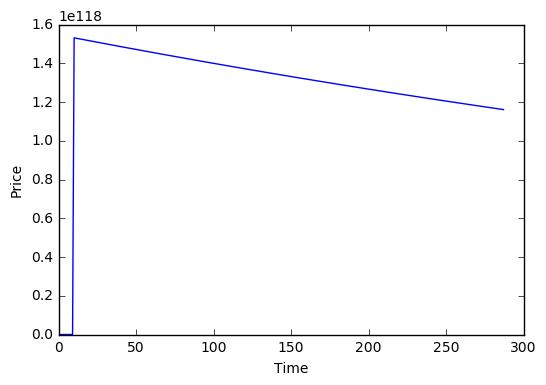

In [72]:
# plot price
fig_p, ax_p = plt.subplots()
ax_p.plot(range(time), price[0:])
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

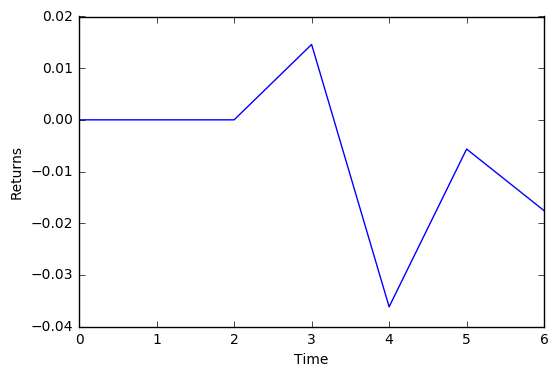

In [65]:
fig_r, ax_r = plt.subplots()
ax_r.plot(range(time-1), lret[0:] )
plt.xlabel('Time')
plt.ylabel('Returns')

0.5

In [9]:
fraction_type2 = np.zeros([time, 1])
price = np.zeros([time, 1])
returns = np.zeros([time,1])

In [14]:
price_deviation_from_fundamental = np.zeros([time,1])  # previously x
accumulated_profits1 = np.zeros([time,1])        
accumulated_profits2 = np.zeros([time, 1])       
share_holdings_type1 = 0.5 * np.ones([time,1])   # previously z1
share_holdings_type2 = 0.5 * np.ones([time,1])   # previously z2
pricing_noise = noise_std * np.random.randn(time) # previously eps
normalized_acc_profits = np.zeros([time,1])

In [11]:
# fraction of agents
fraction_type2[0] = 0.5
fraction_type2[1] = fraction_type2[0]
fraction_type2[2] = fraction_type2[1]
fraction_type2[3] = fraction_type2[2]

In [12]:
# x = price - pstar
price_deviation_from_fundamental[0] = init_price_dev_fundament
price_deviation_from_fundamental[1] = price_deviation_from_fundamental[0]
price_deviation_from_fundamental[2] = price_deviation_from_fundamental[1]
price_deviation_from_fundamental[3] = price_deviation_from_fundamental[2]

p = fundamental_price + price_deviation_from_fundamental

# Sequence of events / simulation

In [19]:
# start at t = 5 to allow for lags
for t in range(4,time):
    # update utility
    # simplified equation from paper(see GHW equation(12))
    # u1(t) = -0.5*(x(t-1)-v*x(t-3))^2;
    # u2(t) = -0.5*(x(t-1) - x(t-3) - g*(x(t-3)-x(t-4)))^2;
    # detaled one period profits using last period holdings
    profits_type1 = returns[t-1]* share_holdings_type1[t-2] - risk_adjustment * 0.5 * risk_av_variance * share_holdings_type1[t-2]**2
    profits_type2 = returns[t-1]* share_holdings_type2[t-2] - risk_adjustment * 0.5 * risk_av_variance * share_holdings_type2[t-2]**2
    # accumulated fitness
    accumulated_profits1[t-1] = profits_type1 + fitness_memory_strenght * accumulated_profits1[t-2]
    accumulated_profits1[t-1] = profits_type2 + fitness_memory_strenght * accumulated_profits2[t-2]
    # normalization for logistice
    norm = np.exp( intensity_of_choice * accumulated_profits1[t-1]) + np.exp( intensity_of_choice * accumulated_profits1[t-1])
    normalized_acc_profits[t] = norm
    # basic n2tilde (before adjustment)
    n2tilde = np.exp( intensity_of_choice * accumulated_profits2[t-1]) / norm
    # emergency check to make sure still in range, if not set to 0.5
    if np.isnan(n2tilde):
        n2tilde = 0.5
    # adjustment to n, see paper
    fraction_type2[t] = n2tilde * np.exp( -(price_deviation_from_fundamental[t-1]) ** 2 / bubble_sensitivity)
    # x(t+1) ( p(t+1)) forecasts
    type1_forecast_p = fundamentalist_adaptive_parameter * (price_deviation_from_fundamental[t-1]) # type 1 price forecast for t+1
    type2_forecast_p = price_deviation_from_fundamental[t-1] + chartist_adaptive_parameter * (price_deviation_from_fundamental[t-1]-price_deviation_from_fundamental[t-2]) # type 2 price forecast for t+1
    # new price for today from t+1 forecasts (note timing)
    price_deviation_from_fundamental[t] = 1/(1+discount_rate) * (((1-share_holdings_type2[t])* type1_forecast_p + share_holdings_type2[t]*type2_forecast_p ) + pricing_noise[t])
    price[t] = price_deviation_from_fundamental[t] + fundamental_price
    # returns time path
    # R[t-1] = p[t+1] - pstar - (1+r)*(p[t]-pstar) + dstd*np.randn(1)
    returns[t] = price_deviation_from_fundamental[t] - price_deviation_from_fundamental[t-1]
    # portfolio decisions
    share_holdings_type1[t] = ( type1_forecast_p - price_deviation_from_fundamental[t])/risk_av_variance
    share_holdings_type2[t] = ( type2_forecast_p - price_deviation_from_fundamental[t])/risk_av_variance

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: overflow encountered in exp
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: divide by zero encountered in true_divide
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: RuntimeWarning: overflow encountered in true_divide
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: invalid value encountered in multiply


## Log returns

In [23]:
# log return
lret = np.log(price[1:time]) - np.log(price[0:time-1])
# arithmetic return
ret = price[1:T] / price[0:time-1]-1
ghret = price[1:T] - dividends - (1+r) * price[0:time-1]

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


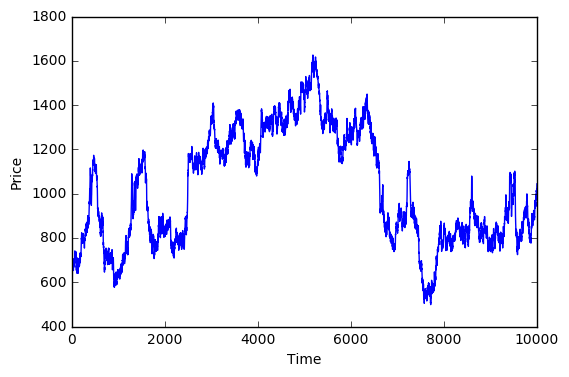

In [26]:
# plot price
fig_p, ax_p = plt.subplots()
ax_p.plot(range(T), p[0:])
plt.xlabel('Time')
plt.ylabel('Price')

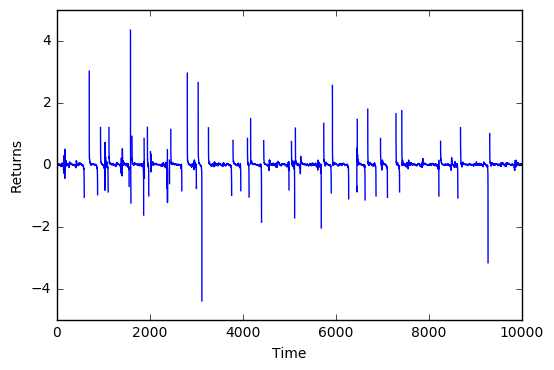

In [27]:
fig_r, ax_r = plt.subplots()
ax_r.plot(range(T-1), lret[0:] )
plt.xlabel('Time')
plt.ylabel('Returns')